In [1]:
import os
from bingX import BingX
import mplfinance as mpl
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

api_key = os.environ.get("BINGX_API_KEY","")
secret_key = os.environ.get("BINGX_SECRET_KEY","")


bingx_client = BingX(api_key, secret_key)



date = datetime(2024,3,31,12,0,0)
date_end = datetime(2024,4,2,12,0,0)

fecha = int(date.timestamp() * 1000)
fecha_end = int(date_end.timestamp() * 1000)

intervals = ["1M","1d","4h","1h","30m","15m","5m","3m","1m"]
data =[bingx_client.perpetual_v2.market.get_k_line_data(symbol="BTC-USDT",interval=interval,start_time=fecha,end_time=fecha_end) for interval in intervals ]

df = pd.DataFrame(data[3])
df['time'] = pd.to_datetime(df['time'],unit='ms')
df = df.astype({'open':'float'})
df = df.astype({'close':'float'})
df = df.astype({'high':'float'})
df = df.astype({'low':'float'})
df= df.astype({'volume':'float'})

df = df.set_index('time',inplace=False)

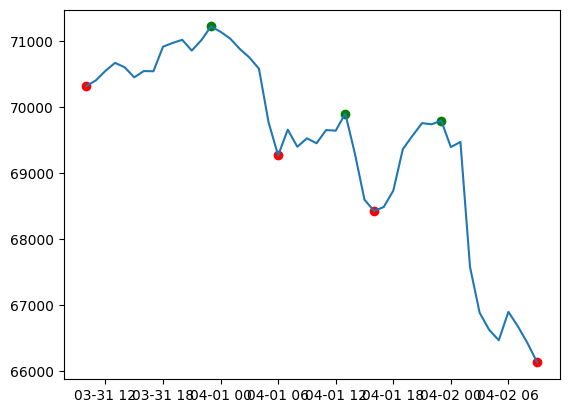

In [2]:
lf = df.drop(columns=['volume','open','close'])
lf['median'] = np.abs(lf['high'] + lf['low']) / 2 
pdf = lf.drop(columns=['high','low'])
n = 5
lf['min'] = lf.iloc[argrelextrema(lf['median'].values, np.less_equal,
                    order=n)[0]]['median']
lf['max'] = lf.iloc[argrelextrema(lf['median'].values, np.greater_equal,
                    order=n)[0]]['median']

plt.scatter(lf.index,lf['min'],c='r')
plt.scatter(lf.index,lf['max'],c='g')
plt.plot(lf.index,lf['median'])
plt.show()